Auteurs:
- Louis PAGNIER
- Léo SRON
- Anthony BERNARD
- Junyi LI
- David FRECON

# Détection d'anomalies dans le système SWaT (Secure Water Treatment)

## Introduction

Dans ce notebook, nous allons essayer de prédire les attaques sur le système SWaT à partir des données fournies dans le dataset SWaT.A3 qui répertorie des données du 20 Juillet 2019.   
Dans ce jeu de données, 6 attaques ont été réalisées sur le système SWaT à des moments différents de la journée.

## Import des librairies

In [68]:
import pandas as pd
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_exploration_utils import *
from mlsecu.data_preparation_utils import *
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt

## Définition des fonctions

Dans un premier temps, nous allons nous concentrer uniquement sur les capteurs du système et laisser de côté les pompes.

In [69]:
sensor_regex = re.compile(r'^(A|F|L|P)IT \d{3}$')

In [70]:
def normalize_df(df):
    """
    Normalize the dataset by using the min-max normalization.
    """
    df_norm = df.copy()
    for col in df_norm.columns:
        if col not in ['Timestamp', 'Attack', 'Label']:
            df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())
    return df_norm

In [71]:
def load_df(name, only_sensors=True):
    """
    Load the dataset from the excel file.
    The parameter only_sensors allows to load only the sensors and not the pumps.
    """
    df = pd.read_excel(name, skiprows=[0, 2])
    if only_sensors:
        sensor_cols = [col for col in df.columns if sensor_regex.match(col) or col in ['Timestamp', 'Attack', 'Label']]
        df = df[sensor_cols]
    return df

In [117]:
def clean_df(df):
    """
    Clean the dataset by removing NaN values and replacing them by the corresponding missing values.
    """
    df['Attack'] = df['Attack'].fillna('benign')
    df['Label'] = df['Label'].fillna(0)
    df['Label'] = df['Label'].astype(int)
    df = df.drop(columns=['AIT 401'])
    df = df.dropna(axis=0)
    for col in df.columns:
        if col in ['Timestamp', 'Attack', 'Label']:
            continue
        # replace dictionary values
        if col[:2] == 'LS':
            df[col] = df[col].apply(lambda x: x[-2])
            df[col] = df[col].astype(int)
        # delete constant columns
        if df[col].std() == 0:
            df = df.drop(columns=[col])
    return df

In [126]:
def extract_features(df):
    """
    Extract the features from the dataset.
    """
    cols = [col for col in df.columns if col not in ['Timestamp', 'Attack', 'Label']]
    df_X = df[cols]
    return df_X

def extract_labels(df, label_col='Label'):
    """
    Extract the labels from the dataset.
    """
    return df[label_col]

In [135]:
def visualize_df(df, outlier_col='Label', title='PCA', targets=[0, 1], colors=['b', 'r']):
    """
    Visualize the dataset by using PCA to reduce the dimensionality.
    """
    df_X = extract_features(df)
    df_y = extract_labels(df, outlier_col)
    
    pca = PCA(n_components=2)
    df_X_pca = pca.fit_transform(df_X)
    df_X_pca = pd.DataFrame(df_X_pca, columns=['PC1', 'PC2'])
    df_X_pca['Label'] = df_y
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title)
    for target, color in zip(targets, colors):
        indices_to_keep = df_X_pca['Label'] == target
        ax.scatter(df_X_pca.loc[indices_to_keep, 'PC1'], df_X_pca.loc[indices_to_keep, 'PC2'], c=color, s=50)
    ax.legend(targets)
    ax.grid()
    plt.show()
    

In [141]:
def visualize_dfs(dfs, outlier_cols=['Label'], titles=['PCA'], targets=[0, 1], colors=['b', 'r']):
    """
    Visualize multiple datasets in a row by using PCA.
    """
    fig, axs = plt.subplots(1, len(dfs), figsize=(10, 5))
    for i, df in enumerate(dfs):
        df_X = extract_features(df)
        df_y = extract_labels(df, outlier_cols[i])
        
        pca = PCA(n_components=2)
        df_X_pca = pca.fit_transform(df_X)
        df_X_pca = pd.DataFrame(df_X_pca, columns=['PC1', 'PC2'])
        df_X_pca['Label'] = df_y
        
        axs[i].set_xlabel('PC1')
        axs[i].set_ylabel('PC2')
        axs[i].set_title(titles[i])
        for target, color in zip(targets, colors):
            indices_to_keep = df_X_pca['Label'] == target
            axs[i].scatter(df_X_pca.loc[indices_to_keep, 'PC1'], df_X_pca.loc[indices_to_keep, 'PC2'], c=color, s=50)
        axs[i].legend(targets)
        axs[i].grid()
    plt.show()

In [129]:
def get_confusion_matrix(df, prediction_col, label_col):
    """
    Compute the confusion matrix from the dataset.
    """
    TP = df[(df[prediction_col] == 1) & (df[label_col] == 1)].shape[0]
    TN = df[(df[prediction_col] == 0) & (df[label_col] == 0)].shape[0]
    FP = df[(df[prediction_col] == 1) & (df[label_col] == 0)].shape[0]
    FN = df[(df[prediction_col] == 0) & (df[label_col] == 1)].shape[0]
    return TP, TN, FP, FN

In [130]:
def compute_accuracy(df, prediction_col, label_col='Label'):
    """
    Compute the accuracy from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return (TP + TN) / (TP + TN + FP + FN)

def compute_precision(df, prediction_col, label_col='Label'):
    """
    Compute the precision from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return TP / (TP + FP)

def compute_recall(df, prediction_col, label_col='Label'):
    """
    Compute the recall from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    return TP / (TP + FN)

In [131]:
def display_metrics(df, prediction_col, label_col='Label'):
    """
    Display the accuracy, precision and recall from the dataset.
    """
    TP, TN, FP, FN = get_confusion_matrix(df, prediction_col, label_col)
    print('Accuracy: {:.2f}'.format((TP + TN) / (TP + TN + FP + FN)))
    print('Precision: {:.2f}'.format(TP / (TP + FP)))
    print('Recall: {:.2f}'.format(TP / (TP + FN)))

## Chargement des données

Avant de commencer, nous allons charger les données du dataset SWaT.A3.

In [132]:
df = load_df('data/SWaT.A3_dataset_Jul 19_labelled.xlsx', only_sensors=False)
df = clean_df(df)
df = normalize_df(df)
df.head()

,Timestamp,Attack,Label,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,AIT 201,AIT 202,...,FIT 502,FIT 503,FIT 504,MV 501,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,P601 Status
0,2019-07-20T04:30:00Z,benign,0,0.0,0.714823,0.5,1.0,1.0,0.869776,0.726909,...,0.600898,0.217869,0.198020,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0
1,2019-07-20T04:30:01Z,benign,0,0.0,0.713530,0.5,1.0,1.0,0.869776,0.726909,...,0.610127,0.217869,0.192244,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0
2,2019-07-20T04:30:02.004013Z,benign,0,0.0,0.712590,0.5,1.0,1.0,0.869776,0.726909,...,0.613869,0.217869,0.192244,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0
3,2019-07-20T04:30:03.004013Z,benign,0,0.0,0.711297,0.5,1.0,1.0,0.869776,0.721581,...,0.596408,0.217869,0.189769,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0
4,2019-07-20T04:30:04Z,benign,0,0.0,0.708358,0.5,1.0,1.0,0.869776,0.721581,...,0.587428,0.217869,0.205446,1.0,0.155526,0.002699,0.140332,0.002333,1.0,0.0


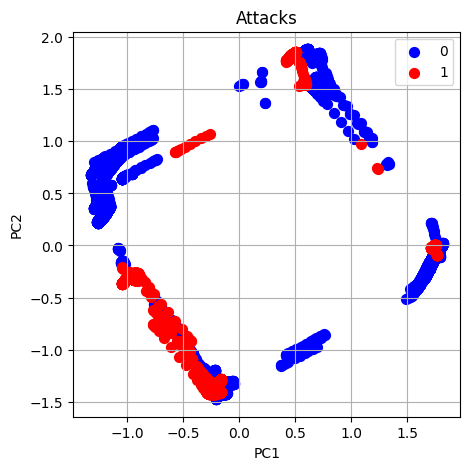

In [140]:
visualize_df(df, title='Attacks')

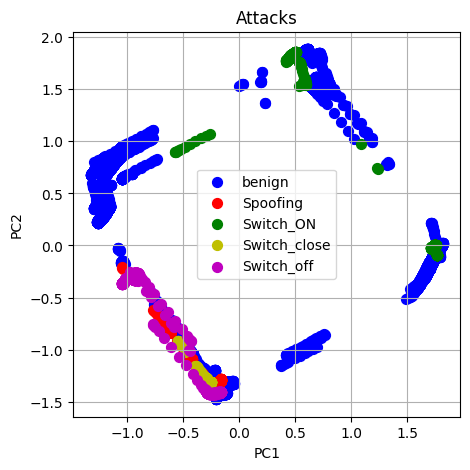

In [138]:
visualize_df(df, title='Attacks', outlier_col='Attack', targets=['benign', 'Spoofing', 'Switch_ON', 'Switch_close', 'Switch_off'], colors=['b', 'r', 'g', 'y', 'm'])

## Détection d'anomalies

Nous allons désormais utiliser les fonctions définies précédemment pour détecter les anomalies dans le dataset.

### Isolation Forest

La première méthode que nous allons utiliser pour déterminer les outliers est Isolation Forest. Cette méthode est basée sur la construction d'arbres de décision aléatoires. Elle permet de déterminer les outliers en fonction du nombre de splits nécessaires pour isoler un point. Plus le nombre de splits est faible, plus le point est considéré comme un outlier.

In [53]:
# Remove extra columns (These columns must not be used for the detection of outliers)
df_if = extract_features(df).copy()

In [54]:
indexes = get_list_of_if_outliers(df_if, 0.03)
df_if['if_outliers'] = 0
df_if.loc[indexes, 'if_outliers'] = 1

In [55]:
# restore extra columns
df_if['Timestamp'] = df['Timestamp']
df_if['Attack'] = df['Attack']
df_if['Label'] = df['Label']

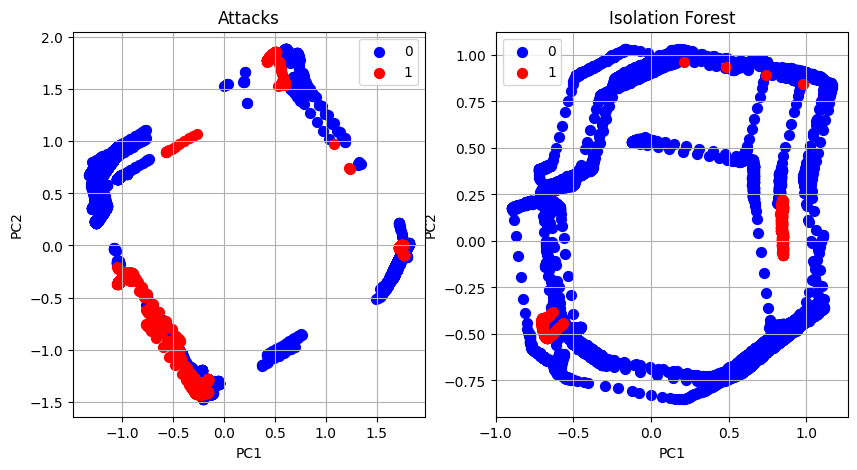

In [136]:
visualize_dfs([df, df_if], ['Label', 'if_outliers'], titles=['Attacks', 'Isolation Forest'])

In [57]:
display_metrics(df_if, 'if_outliers')

Accuracy: 0.82
Precision: 0.31
Recall: 0.06


On peut voir que la méthode Isolation Forest permet de détecter les anomalies avec une accuracy de 0.82, une precision de 0.32 et un recall de 0.06.  
Ces résultats sont assez mauvais. Dans notre cas, la métrique la plus importante est le recall car elle indique le nombre d'attaques détectées par rapport au nombre d'attaques réelles.

# Etudes des données

In [58]:
print("La taille du dataset est", len(df))

attack_labels = df['Attack'].unique()

# Print the unique attack labels
print("Les types d'attaque sont", attack_labels)
print ("Le nombre d'attaques 'non-béninge' est", len(df.loc[df.Label == 1]))

La taille du dataset est 14996
Les types d'attaque sont ['benign' 'Spoofing' 'Switch_ON' 'Switch_close' 'Switch_off']
Le nombre d'attaques 'non-béninge' est 2553


5 types d'attaque:

-benign: Attaque bénigne, labelisée 0;

-Spoofing: Attque impliquant une usurpation d'identité, labélisée 1;

-Switch_ON:

-Switch_close:

-Switch_off:

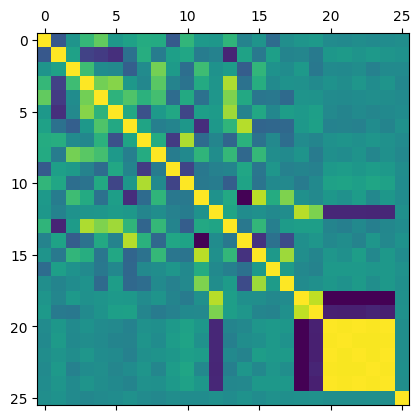

In [59]:
df_feat = extract_features(df).copy()
corr_matrix = df_feat.corr()

# Print the correlation matrix
corr_matrix.style.background_gradient(cmap='coolwarm')
plt.matshow(corr_matrix)

Correlation élevée entre features FIT 501	FIT 502	FIT 503	FIT 504	PIT 501	PIT 502	PIT 503

In [60]:
spoof_attacks = df[df['Attack'] == 'Spoofing']
avg_sensor_readings_before_spoof = spoof_attacks.iloc[:24, 1:].mean(numeric_only=True)
avg_sensor_readings_after_spoof = spoof_attacks.iloc[24:, 1:].mean(numeric_only=True)
change_in_avg_sensor_readings = avg_sensor_readings_after_spoof - avg_sensor_readings_before_spoof
print(change_in_avg_sensor_readings)

Label      0.000000
FIT 101    0.000000
LIT 101   -0.001740
AIT 201   -0.001286
AIT 202   -0.108577
AIT 203   -0.033475
FIT 201   -0.000042
AIT 301   -0.005744
AIT 302   -0.335001
AIT 303    0.051427
FIT 301    0.356878
LIT 301    0.024642
AIT 402   -0.006175
FIT 401    0.643607
LIT 401    0.218727
AIT 501    0.005288
AIT 502    0.018888
AIT 503   -0.139441
AIT 504    0.001845
FIT 501   -0.000230
FIT 502    0.007311
FIT 503   -0.000929
FIT 504   -0.001606
PIT 501    0.000680
PIT 502   -0.000079
PIT 503   -0.000198
FIT 601   -0.000172
dtype: float64


Le sensor LIT 401 réagit aux attaques de spoofing.

In [61]:
on_attacks = df[df['Attack'] == 'Switch_ON']
avg_sensor_readings_before_on = on_attacks.iloc[:24, 1:].mean(numeric_only=True)
avg_sensor_readings_after_on = on_attacks.iloc[24:, 1:].mean(numeric_only=True)
change_in_avg_sensor_readings = avg_sensor_readings_after_on - avg_sensor_readings_before_on
print(change_in_avg_sensor_readings)

Label      0.000000
FIT 101    0.496098
LIT 101   -0.126791
AIT 201   -0.631972
AIT 202   -0.194200
AIT 203   -0.001115
FIT 201   -0.013920
AIT 301    0.007977
AIT 302    0.240888
AIT 303   -0.045009
FIT 301   -0.632642
LIT 301    0.452214
AIT 402   -0.013356
FIT 401    0.003883
LIT 401   -0.166852
AIT 501   -0.001049
AIT 502   -0.013213
AIT 503   -0.091328
AIT 504    0.004113
FIT 501    0.001735
FIT 502    0.003527
FIT 503   -0.003053
FIT 504   -0.000491
PIT 501   -0.002491
PIT 502    0.000151
PIT 503   -0.000981
FIT 601   -0.000046
dtype: float64


Le sensor LIT 301 réagit aux attaques de type switch_on.

In [62]:
off_attacks = df[df['Attack'] == 'Switch_off']
avg_sensor_readings_before_off = off_attacks.iloc[:24, 1:].mean(numeric_only=True)
avg_sensor_readings_after_off = off_attacks.iloc[24:, 1:].mean(numeric_only=True)
change_in_avg_sensor_readings = avg_sensor_readings_after_off - avg_sensor_readings_before_off
print(change_in_avg_sensor_readings)

Label      0.000000
FIT 101    0.000000
LIT 101   -0.001081
AIT 201    0.000975
AIT 202   -0.192117
AIT 203   -0.063567
FIT 201    0.000028
AIT 301    0.018448
AIT 302    0.197854
AIT 303    0.019823
FIT 301    0.003380
LIT 301   -0.080635
AIT 402    0.002769
FIT 401   -0.000864
LIT 401   -0.286237
AIT 501    0.008790
AIT 502    0.002415
AIT 503   -0.013576
AIT 504    0.013135
FIT 501    0.001780
FIT 502   -0.007835
FIT 503   -0.000899
FIT 504    0.004002
PIT 501   -0.003643
PIT 502   -0.000306
PIT 503   -0.002585
FIT 601    0.008376
dtype: float64


Le sensor LIT 401 réagit aux attaques de type switch_off.

### Autres algorithmes

Comme le dataset est labellisé, nous allons utiliser des algorithmes de classification pour avoir une meilleure prédiction.

In [64]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Extract features and labels
X = extract_features(df)
y = extract_labels(df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.97%


In [66]:
df_boost = df.copy()

df_boost['xgb_predictions'] = 0
df_boost.loc[X_test.index, 'xgb_predictions'] = y_pred

display_metrics(df_boost, 'xgb_predictions')

Accuracy: 0.86
Precision: 1.00
Recall: 0.19


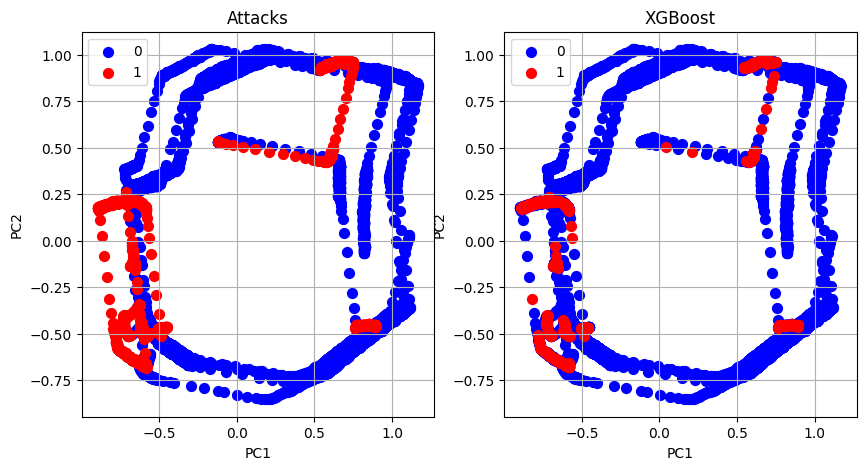

In [67]:
visualize_dfs([df_boost, df_boost], ['Label', 'xgb_predictions'], titles=['Attacks', 'XGBoost'])